# Liquid Rocket Motor Design
This notebook is intended to 

In [68]:
# Import the required python packages
import numpy as np, pandas as pd
from scipy.optimize import root_scalar, root
from scipy import constants

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Set default font sizes for better visibility in presentations
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
})
print("Matplotlib rcParams updated for presentation font sizes.")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import cantera as ct, CoolProp.CoolProp as CP
from ambiance import Atmosphere

from dataclasses import dataclass, field, asdict, astuple

# Import the Jupyter friendly tqdm
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict, Any

# Units
from pint import UnitRegistry
ureg = UnitRegistry(); Q_ = ureg.Quantity

# Helpful constants
g0 = Q_(9.81, 'm/s**2')
G = Q_(constants.gravitational_constant, 'm**3/kg/s**2')
M_earth = Q_(5.972e24, "kg")
mu_earth = G * M_earth
print(f'$\\mu_{{earth}}$ = {mu_earth.to('m**3/s**2'):.3e}')
R_earth = Q_(6_378_137, 'm')
print(f'$R_{{earth}}$ = {R_earth.to('km')}')
omega_earth = 2*np.pi/(24*60*60) * ureg("rad/s")
print(f'$\\omega_{{earth}}$ = {omega_earth.to("rad/s")}')

# Import the compressible flow relations
from modern_aerospace_propulsion.compressible_flow import A_Astar, θ, δ

# Cantera to CoolProp fluid name mapping
can2cool = {
    "O2": "Oxygen",
    "H2": "Hydrogen",
    "CH4": "Methane",
}

# CoolProp to Cantera fluid name mapping
cool2can = {v: k for k, v in can2cool.items()}

@dataclass
class StatePoint:
  """A thermodynamic state point class to represent a specific state."""
  T: Q_
  P: Q_
  h: Q_
  s: Q_
  rho: Q_
  ga: float
  R: Q_
  X: Dict[str, float]
  def asdict(self):
      return asdict(self)
  
def can2statepoint(fluid: ct.Solution) -> StatePoint:
    """Convert a Cantera Solution object to a StatePoint dataclass."""
    return StatePoint(
        T=Q_(fluid.T, 'K'),
        P=Q_(fluid.P, 'Pa'),
        h=Q_(fluid.enthalpy_mass, 'J/kg'),
        s=Q_(fluid.entropy_mass, 'J/kg/K'),
        rho=Q_(fluid.density, 'kg/m**3'),
        ga=fluid.cp_mass / fluid.cv_mass,
        R=Q_(fluid.cp_mass - fluid.cv_mass, 'J/kg/K'),
        X=fluid.X
    )


Matplotlib rcParams updated for presentation font sizes.
$\mu_{earth}$ = 3.986e+14 meter ** 3 / second ** 2
$R_{earth}$ = 6378.137 kilometer
$\omega_{earth}$ = 7.27220521664304e-05 radian / second


## Design Procedure

1. Select a target thrust ($T$) and specific impulse ($I_{sp}$) at a specified altitude ($h$)**.
2. Calculate the required mass flow rate ($\dot{m}$) and exit velocity ($V_{exit}$).

**Vacuum conditions are assumed for altitudes > 80 km.

## Rocket Performance Metrics
In this section, the major rocket engine performance metrics are defined including--
1. Thrust
2. Effective exit velocity
3. Exit Mach number
4. Specific Impulse

In [69]:
# System level performance metrics 

# Effective nozzle exit velocity
def c_exit(Mach: float, ga: float, R: Q_, Tt: Q_, pt: Q_, p_amb: Q_) -> Q_:
  """Calculate and return the effective nozzle exit velocity given
  **Mach** - the nozzle exit Mach number,
  **ga** - the ratio of specific heats,
  **R** - the gas constant,
  **Tt** - the total temperature,
  **pt** - the total pressure, and
  **p_amb** - the ambient static pressure"""
  print(f"p_amb: {p_amb}, pt: {pt}")
  return (np.sqrt(ga*R*Tt/θ(Mach, ga)) * (Mach + (1-p_amb/pt*δ(Mach, ga))/(ga*Mach))).to("m/s")

# Nozzle exit Mach number
def Mach_exit(epsilon: float, ga: float) -> float:
  """Calculate and return the nozzle exit Mach number given
  **epsilon** - the expansion ratio
  **ga** - the ratio of specific heats"""
  return root_scalar(lambda Mach, ga: A_Astar(Mach, ga) - epsilon,
                     args=(ga,), bracket=[1, 100]).root

def massflow(ga: float, R: Q_, Tt: Q_, pt: Q_, Athroat: Q_) -> Q_:
  """Calculate and return the mass flow given
  **ga** - the ratio of specific heats,
  **R** - the gas constant,
  **Tt** - the total temperature,
  **pt** - the total pressure, and
  **Athroat** - the (assumed choked) nozzle throat area"""
  return (pt*np.sqrt(ga/R/Tt)*(2/(ga+1))**((ga+1)/2/(ga-1))*Athroat).to('kg/s')

# Specific Impulse
def Isp(Mach, ga, R, Tt, pt, p_amb):
  """Calculate and return the specific impulse in seconds given
  **Mach** - the nozzle exit Mach
  **ga** - the ratio of specific heats
  **R** - the gas constant
  **Tt** - the total temperature
  **pt** - the total pressure
  **p_amb** - the ambient static pressure"""
  return float(c_exit(Mach, ga, R, Tt, pt, p_amb)/g0.m_as("m/s**2"))

# Thrust
def thrust(Mach, ga, R, Tt, pt, p_amb):
  """Calculate and return the specific impulse in seconds given
  **Mach** - the nozzle exit Mach
  **ga** - the ratio of specific heats
  **R** - the gas constant
  **Tt** - the total temperature"""
  return Isp(Mach, ga, R, Tt, pt, p_amb) * g0.m_as("m/s**2")

## Rocket Design Parameters
In this section, the major rocket design parameters are specified.

In [70]:
design = {"fuel": {'CH4': 1}, 
          "oxidizer": {'O2': 1},
          "phi": 4.0/3.5,
          "subcooling": Q_(10, 'K'),
          "pump_efficiency": 0.7,
          "thrust": Q_(2.74e6, 'N'),  # 2.74 MN
          "Isp": Q_(350, 's'),        # 350 seconds
          "altitude": Q_(80_000, 'm') # 100 km
         }

In [71]:
# Equilibrium combustor model
def combustor(fuel: dict, oxidizer: dict, phi: float, p: Q_ = Q_(1e5, 'Pa'), T: Q_ = Q_(300, 'K')):
  """**combustor** Calculate the equilibrium combustion products given the 
  **fuel** (dict): fuel constituents and their amounts as mole fractions,
  **oxidizer** (dict): oxidizer constituents and their amounts as mole fractions,
  **phi** (float): equivalence ratio,
  **p** (Q_): pressure,
  **T** (Q_): temperature"""
  
  gas = ct.Solution('gri30.yaml')
  gas.TP = T.m_as("K"), p.m_as("Pa")
  gas.set_equivalence_ratio(phi, fuel, oxidizer, basis='mole')
  gas.equilibrate('HP')

  return can2statepoint(gas)


In [72]:
# Calculate the required exit velocity to meet the design Isp
v_exit_required = design["Isp"] * g0
print(f"Required exit velocity to meet design Isp: {v_exit_required:.2f}")

# Calculate the mass flow rate required to meet the design thrust
mdot_total = design["thrust"] / v_exit_required
print(f"\nRequired total mass flow rate to meet design thrust: {mdot_total.to('kg/s'):.2f}")

# Calculate the ambient pressure at the design altitude
p_amb = Q_(Atmosphere(design["altitude"].to('m').m_as('m')).pressure, 'Pa')[0]
print(f"\nAmbient pressure at {design['altitude']}: P_amb = {p_amb:.2f}")

# Assume a nominal mass average combustor inflow temperature
Tt_combustor_inflow = Q_(300, 'K')
print(f"\n❗️ Assumed combustor inflow total temperature: Tt_inflow = {Tt_combustor_inflow:.2f}")

# Solve for the combustor inflow temperature, the chamber pressure and the exit Mach number
def fmin(X):
  """Objective function to minimize for design point"""

  # Unpack the design variables
  p_combustor, M_exit, A_throat = X

  # Calculate the combustor exit conditions
  combustor_exit = combustor(design["fuel"], design["oxidizer"], design["phi"], 
                             p=p_combustor*ureg('Pa'), T=Tt_combustor_inflow)
  
  # Shortcut variables
  ga = combustor_exit.ga; R = combustor_exit.R; Tt = combustor_exit.T; pt = combustor_exit.P
  print(f"Combustor exit conditions at p_combustor={p_combustor/1e6:.2f} MPa, M_exit={M_exit:.2f}, A_throat={A_throat:.4f} m²:")
  print(f" - Tt={Tt:.2f}, pt={pt/1e6:.2f} MPa, R={R:.2f}, ga={ga:.4f}")
  
  return [
      # Exit velocity match
      (c_exit(M_exit, ga, R, Tt, pt, p_amb).m_as('m/s') - v_exit_required.m_as('m/s')) / v_exit_required.m_as('m/s'),
      # Exit pressure match
      (pt/δ(M_exit, ga) - p_amb)/(pt/δ(M_exit, ga)),
      # Mass flow match
      (massflow(ga, R, Tt, pt, A_throat*ureg('m**2')) - mdot_total)/mdot_total
      ]

# Find the combustor pressure, exit Mach number and throat area that minimize fmin
results = root(fmin, [100e6, 5, 0.1], method="hybr")

if results.success:
  p_combustor, M_exit, A_throat = results.x
  print(f"✓ Converged: p={p_combustor/1e6:.2f} MPa, M={M_exit:.2f}, A*={A_throat:.4f} m²")
else:
  print(f"✗ Failed to converge: {results.message}")

# Calculate the combustor exit conditions
combustor_exit = combustor(design["fuel"], design["oxidizer"], design["phi"], p=p_combustor, T=Tt_combustor_inflow)
print(f"\n🔥 Combustor exit conditions:\n - Temperature: {combustor_exit.T:.2f}\n - Pressure: {combustor_exit.P:.2f}\n - Gas constant: {combustor_exit.R:.2f}\n - Gamma: {combustor_exit.ga:.4f}")


Required exit velocity to meet design Isp: 3433.50 meter / second

Required total mass flow rate to meet design thrust: 798.02 kilogram / second

Ambient pressure at 80000 meter: P_amb = 1.05 pascal

❗️ Assumed combustor inflow total temperature: Tt_inflow = 300.00 kelvin
Combustor exit conditions at p_combustor=100.00 MPa, M_exit=5.00, A_throat=0.1000 m²:
 - Tt=4013.20 kelvin, pt=100.00 pascal MPa, R=370.70 joule / kelvin / kilogram, ga=1.1869
p_amb: 1.0524644697315866 pascal, pt: 100000000.0 pascal
Combustor exit conditions at p_combustor=100.00 MPa, M_exit=5.00, A_throat=0.1000 m²:
 - Tt=4013.20 kelvin, pt=100.00 pascal MPa, R=370.70 joule / kelvin / kilogram, ga=1.1869
p_amb: 1.0524644697315866 pascal, pt: 100000000.0 pascal
Combustor exit conditions at p_combustor=100.00 MPa, M_exit=5.00, A_throat=0.1000 m²:
 - Tt=4013.20 kelvin, pt=100.00 pascal MPa, R=370.70 joule / kelvin / kilogram, ga=1.1869
p_amb: 1.0524644697315866 pascal, pt: 100000000.0 pascal
Combustor exit conditions at

CanteraError: 
*******************************************************************************
CanteraError thrown by Phase::setDensity:
density must be positive. density = -8087.147104269187
*******************************************************************************


## Combustion Chamber Conditions

## Storage Conditions
The (cryogenic) propellants are assumed to be stored at a specified amount of subcooling relative to their standard (ambient) pressure boiling points.  `storage_conditions` returns the storage temperature and density for the specified propellant and amount of subcooling.

In [73]:
# Coolprop fluid names
fuel_cp = [can2cool[key] for key in design["fuel"].keys() if design["fuel"][key] > 0]
oxidizer_cp = [can2cool[key] for key in design["oxidizer"].keys() if design["oxidizer"][key] > 0]

print(f"Fuel: {fuel_cp}, Oxidizer: {oxidizer_cp}")

Fuel: ['Methane'], Oxidizer: ['Oxygen']


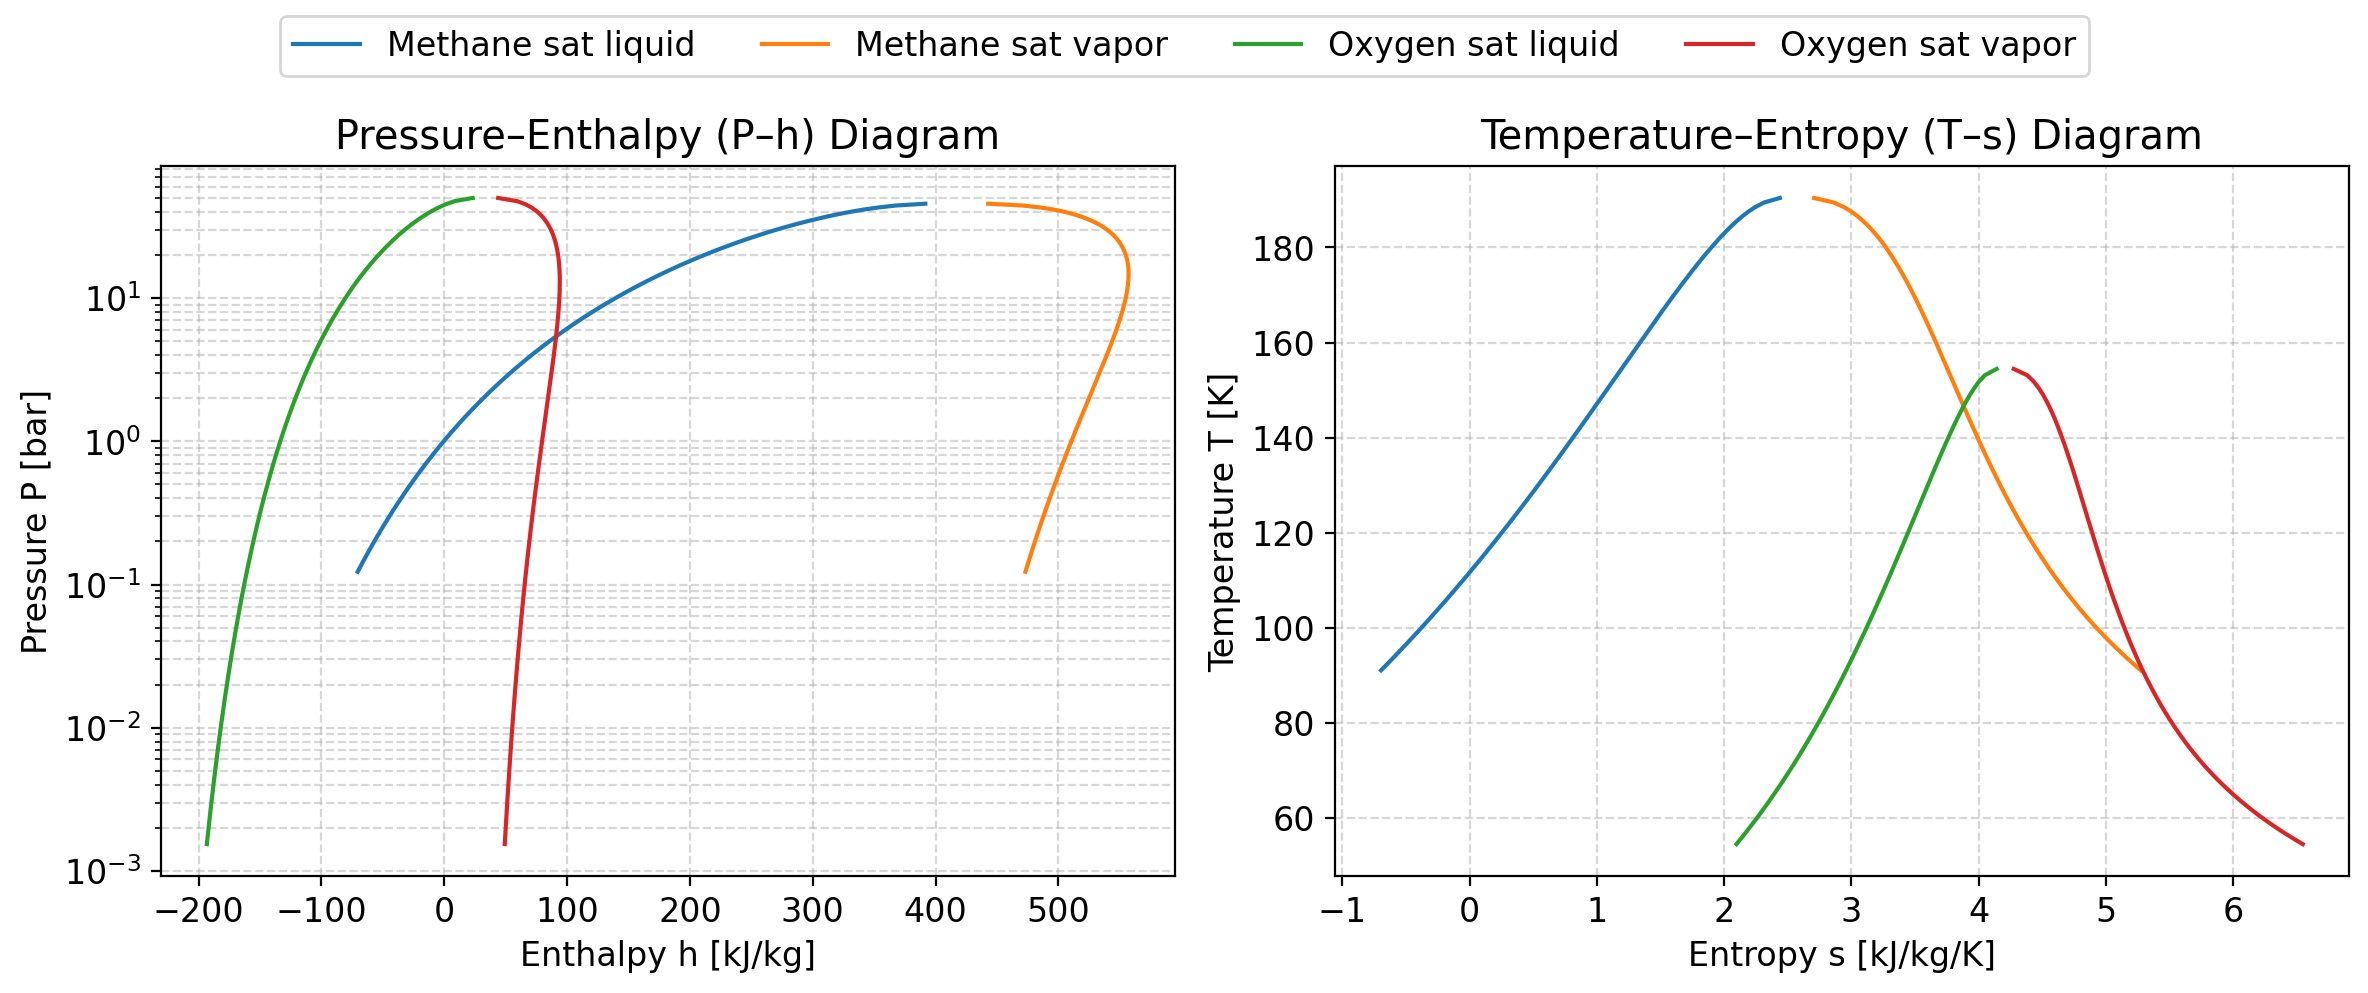

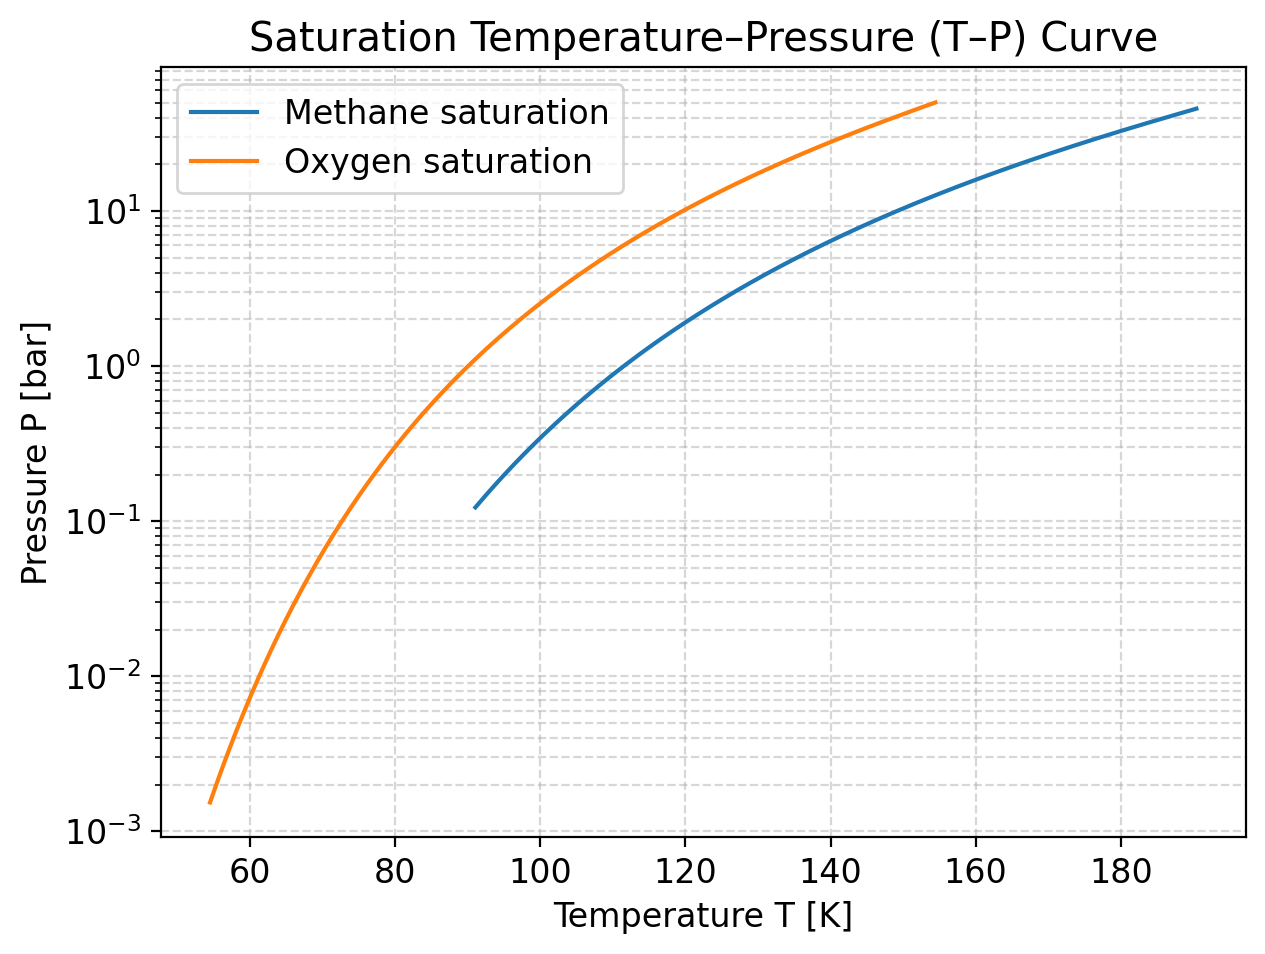

In [31]:
# Utility to build saturation curves for a pure fluid
# CoolProp constant names: ptriple, Ttriple, Pcrit, Tcrit
# We loop over pressures to avoid array broadcast issues in some builds.

def saturation_curves(fluid, n=200):
    P_triple = CP.PropsSI('ptriple', fluid)
    P_crit = CP.PropsSI('Pcrit', fluid)
    # Restrict upper bound slightly below critical to stay in 2-phase region
    pressures = np.logspace(np.log10(P_triple*1.05), np.log10(P_crit*0.995), n)
    T_sat = []
    s_liq = []
    s_vap = []
    for P in pressures:
        try:
            T_sat.append(CP.PropsSI('T','P',P,'Q',0,fluid))
            s_liq.append(CP.PropsSI('Smass','P',P,'Q',0,fluid))
            s_vap.append(CP.PropsSI('Smass','P',P,'Q',1,fluid))
        except ValueError:
            # Skip pressures where saturation properties fail (near critical)
            continue
    return np.array(pressures[:len(T_sat)]), np.array(T_sat), np.array(s_liq), np.array(s_vap)

# Plot Pressure–Entropy diagram (kept for reference)

def plot_ps(fluid_list):
    plt.figure(figsize=(7,5))
    for fluid in fluid_list:
        P, T_sat, s_liq, s_vap = saturation_curves(fluid)
        # Convert units: P Pa -> bar, s J/kg/K -> kJ/kg/K
        plt.plot(s_liq/1e3, P/1e5, label=f"{fluid} sat liquid")
        plt.plot(s_vap/1e3, P/1e5, label=f"{fluid} sat vapor")
    plt.xlabel('Entropy s [kJ/kg/K]')
    plt.ylabel('Pressure P [bar]')
    plt.title('Pressure–Entropy (P–s) Diagram')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend()
    plt.show()

# Plot Temperature–Pressure saturation curve (unchanged per request)

def plot_tp(fluid_list):
    plt.figure(figsize=(7,5))
    for fluid in fluid_list:
        P, T_sat, s_liq, s_vap = saturation_curves(fluid)
        plt.plot(T_sat, P/1e5, label=f"{fluid} saturation")
    plt.xlabel('Temperature T [K]')
    plt.ylabel('Pressure P [bar]')
    plt.title('Saturation Temperature–Pressure (T–P) Curve')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend()
    plt.show()

# New: Combined figure with Pressure–Enthalpy (P–h) and Temperature–Entropy (T–s) subplots

def plot_ph_ts(fluid_list):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    ax_ph, ax_ts = axes
    for fluid in fluid_list:
        P, T_sat, s_liq, s_vap = saturation_curves(fluid)
        # Enthalpy (J/kg) for saturated states
        h_liq = []
        h_vap = []
        for P_single in P:
            try:
                h_liq.append(CP.PropsSI('Hmass','P',P_single,'Q',0,fluid))
                h_vap.append(CP.PropsSI('Hmass','P',P_single,'Q',1,fluid))
            except ValueError:
                h_liq.append(np.nan)
                h_vap.append(np.nan)
        h_liq = np.array(h_liq)/1e3  # kJ/kg
        h_vap = np.array(h_vap)/1e3  # kJ/kg
        P_bar = P/1e5
        # P–h subplot (vapor dome)
        ax_ph.plot(h_liq, P_bar, label=f"{fluid} sat liquid")
        ax_ph.plot(h_vap, P_bar, label=f"{fluid} sat vapor")
        # T–s subplot (vapor dome)
        ax_ts.plot(s_liq/1e3, T_sat, label=f"{fluid} sat liquid")
        ax_ts.plot(s_vap/1e3, T_sat, label=f"{fluid} sat vapor")
    # Style P–h
    ax_ph.set_xlabel('Enthalpy h [kJ/kg]')
    ax_ph.set_ylabel('Pressure P [bar]')
    ax_ph.set_title('Pressure–Enthalpy (P–h) Diagram')
    ax_ph.set_yscale('log')
    ax_ph.grid(True, which='both', ls='--', alpha=0.5)
    # Style T–s
    ax_ts.set_xlabel('Entropy s [kJ/kg/K]')
    ax_ts.set_ylabel('Temperature T [K]')
    ax_ts.set_title('Temperature–Entropy (T–s) Diagram')
    ax_ts.grid(True, which='both', ls='--', alpha=0.5)
    handles, labels = ax_ph.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)
    fig.tight_layout(rect=(0,0,1,0.92))
    plt.show()

# Generate plots for specified fuel & oxidizer
fluids = fuel_cp + oxidizer_cp
plot_ph_ts(fluids)      # New combined figure
# plot_ps(fluids)       # Optional legacy P–s
plot_tp(fluids)       # Existing T–P if needed separately

# Note: These are pure-fluid saturation curves. A reacting fuel/oxidizer mixture
# does not have a simple equilibrium saturation envelope represented in CoolProp.
# For mixtures, thermodynamic paths are computed from combustion products with
# equilibrium chemistry (e.g., Cantera) rather than mixed-phase saturation data.


### T-S Diagram

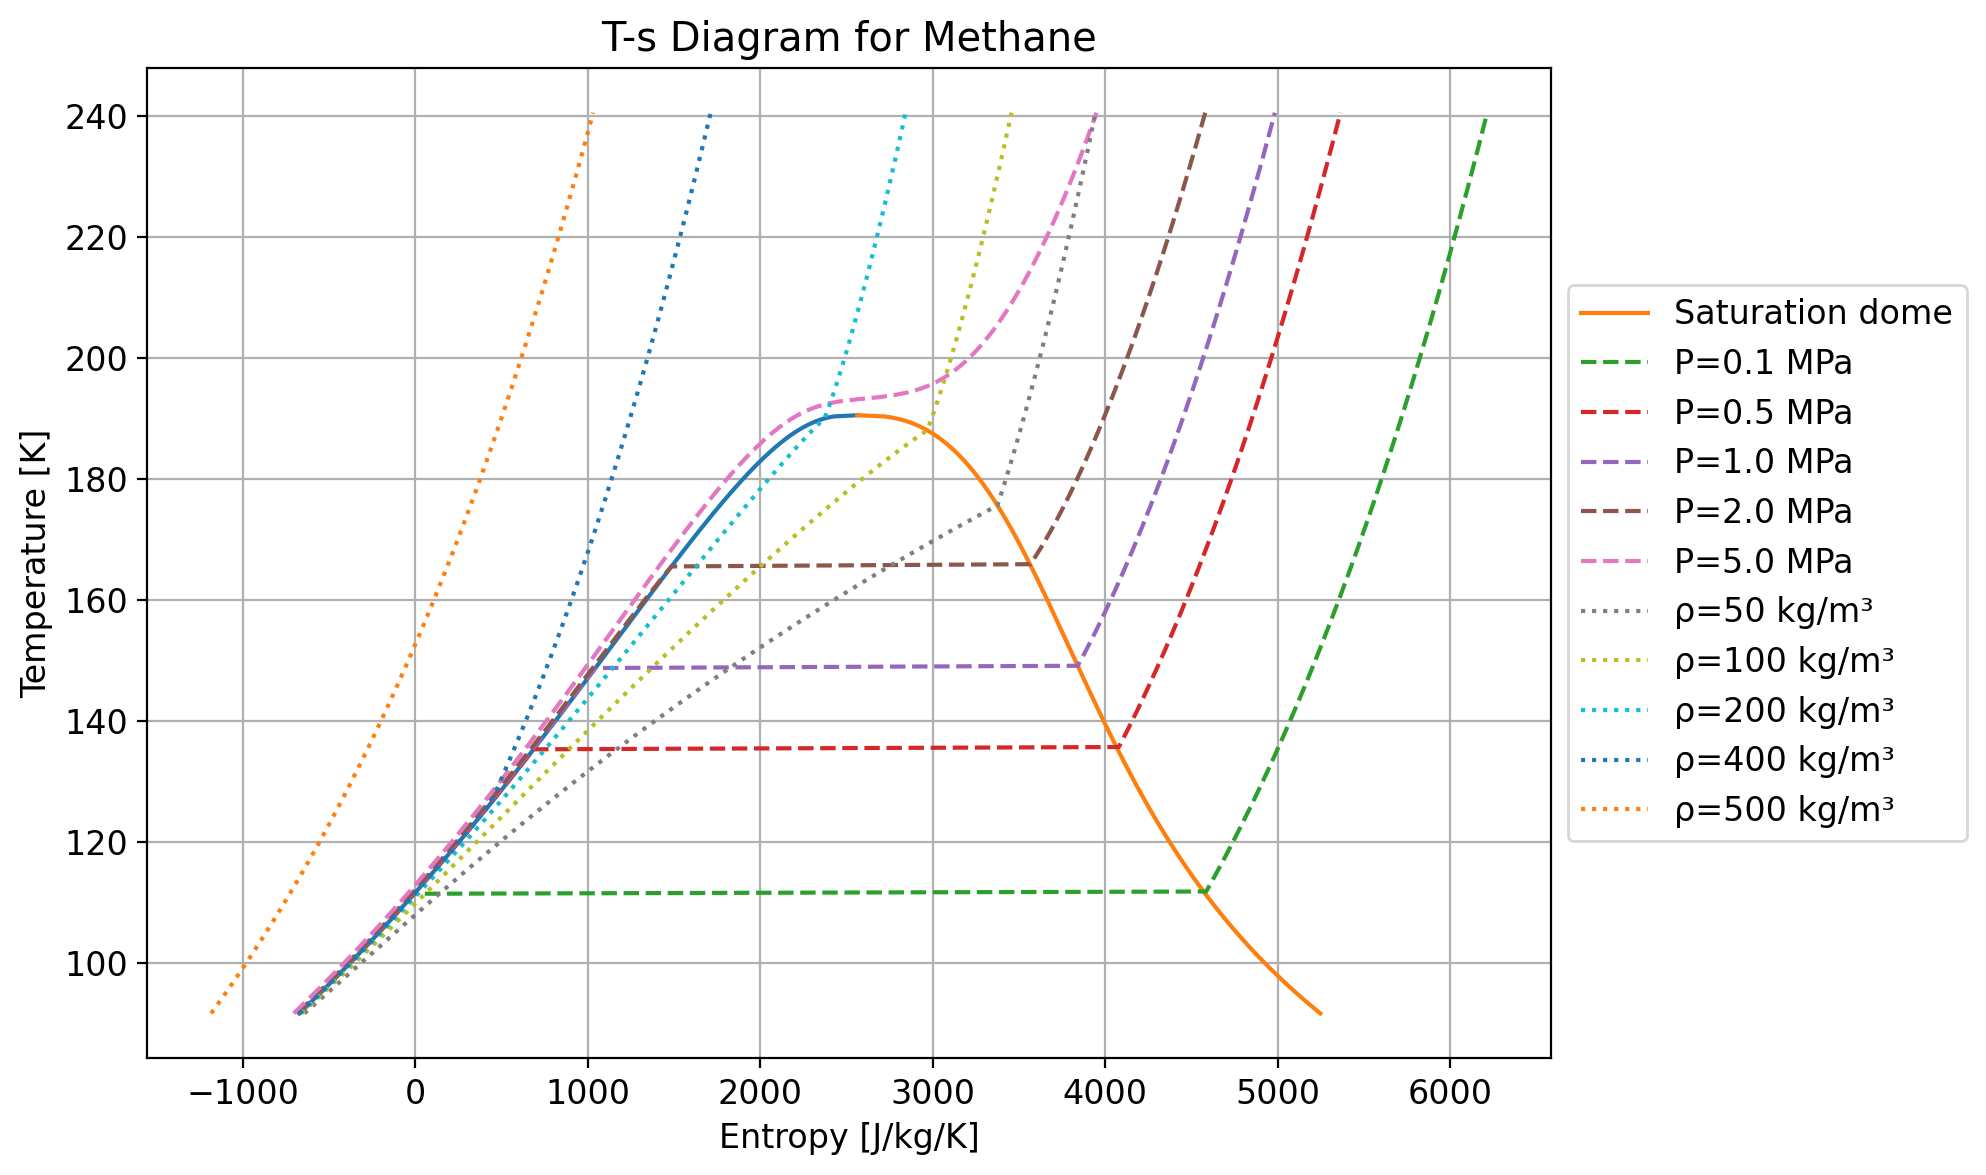

In [61]:

fluid = 'Methane'

# Saturation lines
Tcrit = CP.PropsSI('Tcrit', fluid)
Tmin = CP.PropsSI('Tmin', fluid)

T = np.linspace(Tmin+1, Tcrit, 500)
sL = CP.PropsSI('S','T',T,'Q',0,fluid)
sV = CP.PropsSI('S','T',T,'Q',1,fluid)
pressures = [0.1e6, 0.5e6, 1e6, 2e6, 5e6]   # Pa
densities = [50, 100, 200, 400, 500]      # kg/m³

plt.figure(figsize=(8,6))
plt.plot(sL, T)
plt.plot(sV, T, label="Saturation dome")

# --- Isobars ---
for p in pressures:
    Tline = np.linspace(Tmin+1, Tcrit+50, 400)
    sline = CP.PropsSI('S','T',Tline,'P',p,fluid)
    plt.plot(sline, Tline, '--', label=f"P={p/1e6:.1f} MPa")

# --- Iso-density lines ---
for rho in densities:
    Ts = np.linspace(Tmin+1, Tcrit+50, 400)
    s_vals, T_vals = [], []
    for Ti in Ts:
        try:
            s_vals.append( CP.PropsSI('S','T',Ti,'D',rho,fluid) )
            T_vals.append(Ti)
        except:
            pass
    if len(s_vals)>0:
        plt.plot(s_vals, T_vals, ':', label=f"ρ={rho} kg/m³")

plt.xlabel("Entropy [J/kg/K]")
plt.ylabel("Temperature [K]")
plt.title(f"T-s Diagram for {fluid}")
plt.grid(True)

# Add legend outside plot
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### P-H Diagram

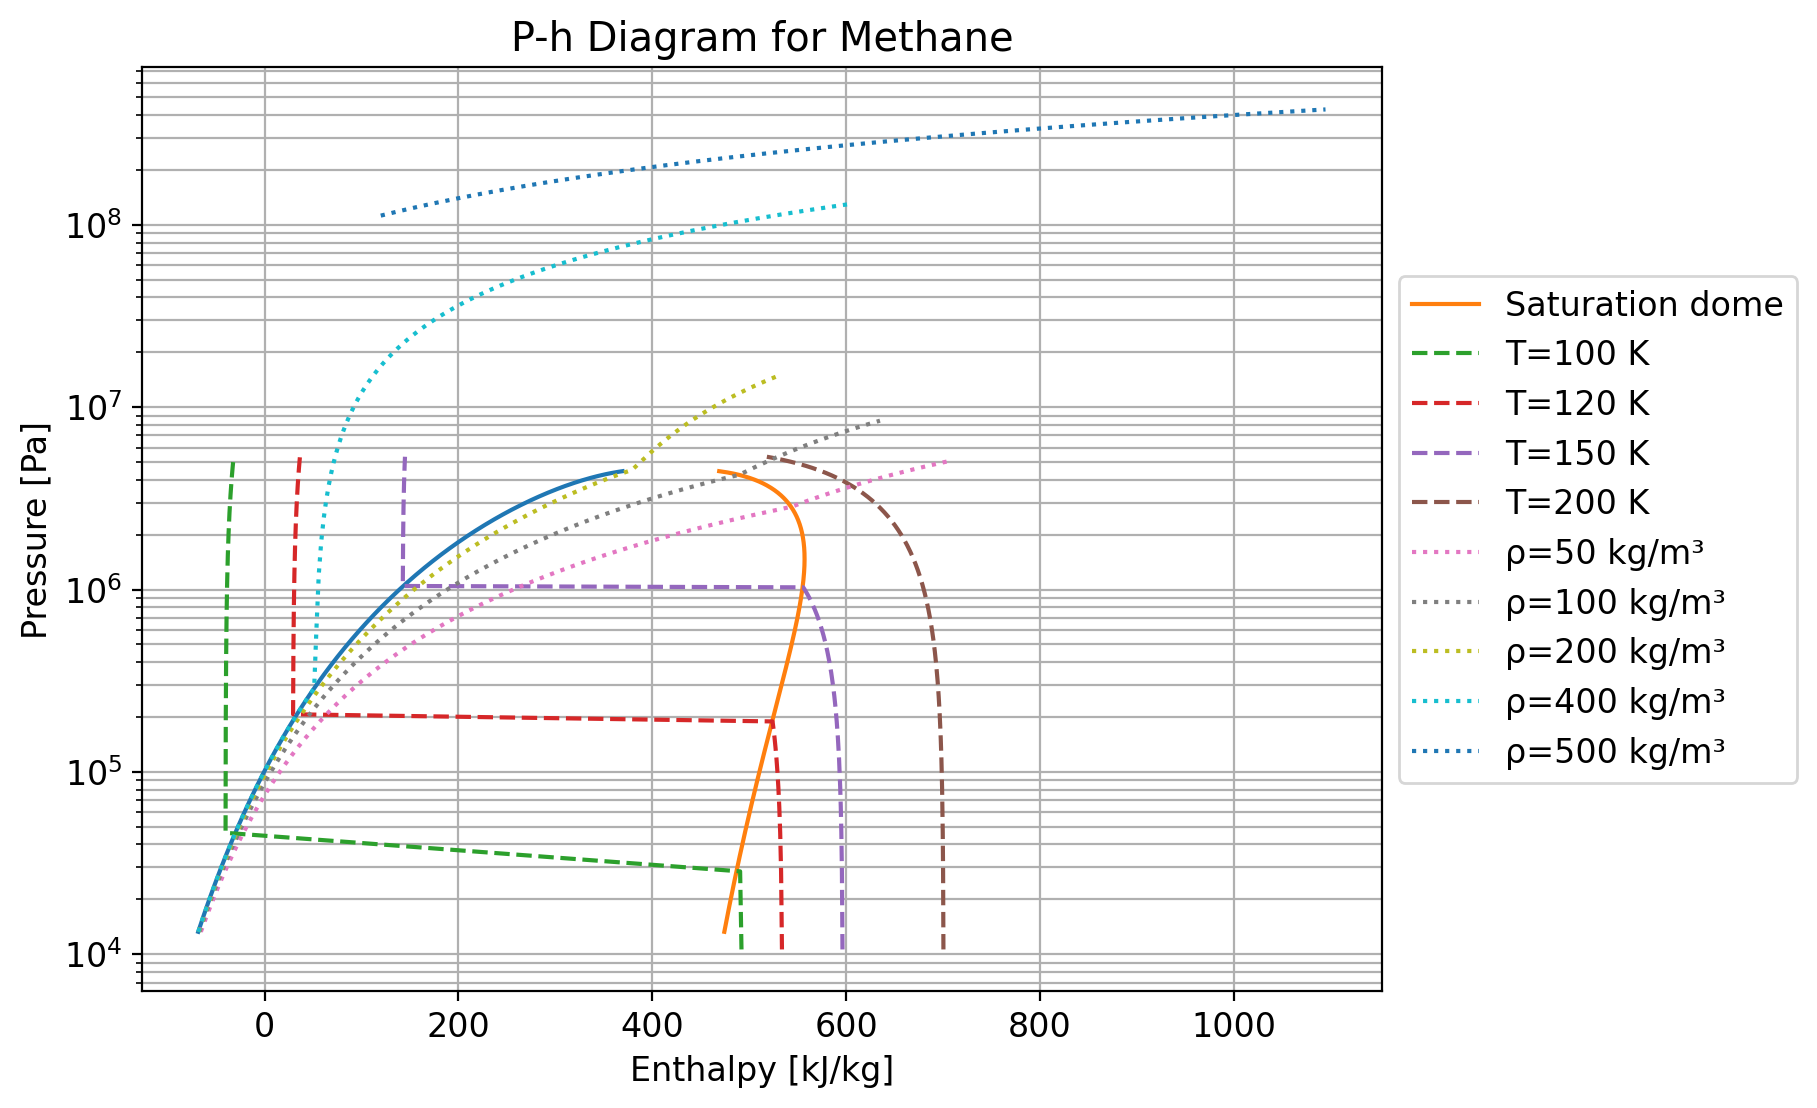

In [60]:

# Saturation curve
Tcrit = CP.PropsSI('Tcrit', fluid)
Tmin = CP.PropsSI('Tmin', fluid)

T_sat = np.linspace(Tmin+1, Tcrit-1, 400)
p_sat = CP.PropsSI('P','T',T_sat,'Q',0,fluid)
hL    = CP.PropsSI('H','T',T_sat,'Q',0,fluid)
hV    = CP.PropsSI('H','T',T_sat,'Q',1,fluid)

temperatures = [100, 120, 150, 200]   # isotherms
densities    = [50, 100, 200, 400, 500]    # iso-density curves

plt.figure(figsize=(8,6))
plt.semilogy(hL/1000, p_sat)
plt.semilogy(hV/1000, p_sat, label="Saturation dome")

# --- Constant-temperature lines ---
p_line = np.linspace(min(p_sat)*0.8, max(p_sat)*1.2, 300)
for T0 in temperatures:
  h_line = CP.PropsSI('H','T',T0,'P',p_line,fluid)
  plt.semilogy(h_line/1000, p_line, '--', label=f"T={T0} K")

# --- Iso-density lines ---
for rho in densities:
    h_vals, p_vals = [], []
    Ts = np.linspace(Tmin+1, Tcrit+50, 300)
    for Ti in Ts:
        try:
            h_vals.append( CP.PropsSI('H','T',Ti,'D',rho,fluid) )
            p_vals.append( CP.PropsSI('P','T',Ti,'D',rho,fluid) )
        except:
            pass
    if len(h_vals)>0:
        plt.semilogy(np.array(h_vals)/1000, p_vals, ':', label=f"ρ={rho} kg/m³")

plt.xlabel("Enthalpy [kJ/kg]")
plt.ylabel("Pressure [Pa]")
plt.title(f"P-h Diagram for {fluid}")
plt.grid(True, which="both")

# Add a legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [151]:
# Determine the tank storage conditions for given propellants by assuming that they are stored with a specified
#  amount of subcooling below their saturation temperature at ambient static pressure.
def storage_conditions(fluid_cp: str, subcool: Q_ = Q_(10, 'K'), P_static: Q_ = Q_(101325*5, 'Pa')) -> Dict[str, Q_]:
  """Determine the tank storage temperature and density for a given fluid,
  static pressure, and subcooling amount below saturation temperature.
  
  Args:
      fluid_cp: CoolProp fluid name (e.g., 'Methane')
      P_static: Ambient static pressure (Pint Quantity)
      subcool: Amount of subcooling below saturation temperature (Pint Quantity)"""
  
  P_static_SI = P_static.to('Pa').magnitude
  T_sat = Q_(CP.PropsSI('T','P',P_static_SI,'Q',0,fluid_cp), 'K')
  T_storage = T_sat - subcool
  rho_storage = Q_(CP.PropsSI('Dmass','P',P_static_SI,'T',T_storage.to('K').magnitude,fluid_cp), 'kg/m**3')
  return {
      'T_storage': T_storage,
      'rho_storage': rho_storage,
      'p_storage': P_static_SI
  }
    

In [154]:
fuel_tank = storage_conditions(fuel_cp[0], design["subcooling"]+25*ureg('K'))  # Extra subcooling for fuel
oxidizer_tank = storage_conditions(oxidizer_cp[0], design["subcooling"])
print(f"Fuel tank storage conditions: T = {fuel_tank['T_storage']:.2f}, ρ = {fuel_tank['rho_storage']:.2f}, p = {fuel_tank['p_storage']/1e5:.2f} bar")
print(f"Oxidizer tank storage conditions: T = {oxidizer_tank['T_storage']:.2f}, ρ = {oxidizer_tank['rho_storage']:.2f}, p = {oxidizer_tank['p_storage']/1e5:.2f} bar")

Fuel tank storage conditions: T = 100.59 kelvin, ρ = 438.43 kilogram / meter ** 3, p = 5.07 bar
Oxidizer tank storage conditions: T = 98.99 kelvin, ρ = 1096.97 kilogram / meter ** 3, p = 5.07 bar


## Pump Design


### Rotor Design

In [135]:
# Target specific speed & diameter
N_specific = 125 # Specific speed
D_specific = 1.25 # Specific diameter
print(f"Specific speed = {N_specific}, Specific Diameter = {D_specific}")

# Design Pressure Rise
delta_p_design = Q_(660, "bar")

# Design head
head_design = (delta_p_design / g0 / fuel_tank['rho_storage']).to('ft')
print(f"Design head = {head_design.to('ft')}")

# Design flow rate
Q_design = Q_(0.4, "m**3/s").to('ft**3/s')
print(f"Design volumetric flow rate = {Q_design} = {Q_design.to("m**3/s")}")

# Design Speed
def N_design(Ns, Q, H) -> Q_:
  """Calculate the design speed in RPM given 
    - Ns: the target specific speed,
    - Q: the design volumetric flow rate in ft**3/s,
    - H: the design pump head in ft"""
  return Ns * H.m_as('ft')**(3/4) / np.sqrt(Q.m_as('ft**3/s')) * ureg('1/min')

# Design Diameter
def D_design(Ds, Q, H) -> Q_:
  """Calculate the design diameter in ft given
    - Ns: the target specific speed,
    - Q: the design volumetric flow rate in ft**3/s,
    - H: the design pump head in ft"""
  return Ds * np.sqrt(Q.m_as("ft**3/s")) / H.m_as('ft')**(1/4) * ureg('ft')

# Design speed
print(f'Design speed = {N_design(N_specific, Q_design, head_design).m_as("1/min")} RPM')

# Design diameter
print(f"Design diameter = {D_design(D_specific, Q_design, head_design).m_as("cm")} cm")

# Max speed
N_max = Q_(40_000, "1/min")

# Solve the the stage head consistent with the max speed
head_stage = (N_max.m_as("1/min")*np.sqrt(Q_design.m_as("ft**3/s"))/N_specific)**(4/3) * ureg("ft")
print(f"\nStage head for max speed of N_max = {N_max} is {head_stage.to_reduced_units()} = {head_stage.to("m")}")

# Convert stage head to pressure rise
stage_delta_p = head_stage * g0 * fuel_tank['rho_storage']
print(f"Stage pressure rise = {stage_delta_p.to('bar')}")

# Calculate the stage diameter for the reduced head
diameter_stage = D_design(D_specific, Q_design, head_stage)
print(f"Stage diameter = {diameter_stage.to("cm")}")

# Number of stages
N_stages = head_design / head_stage
print(f"Number of Stages = {N_stages}")

Specific speed = 125, Specific Diameter = 1.25
Design head = 50344.98410609456 foot
Design volumetric flow rate = 14.12586668859544 foot ** 3 / second = 0.4 meter ** 3 / second
Design speed = 111781.41873737777 RPM
Design diameter = 9.559682648871444 cm

Stage head for max speed of N_max = 40000 / minute is 12790.181477429276 foot = 3898.4473143204427 meter
Stage pressure rise = 167.6735016404827 bar
Stage diameter = 13.465216812699275 centimeter
Number of Stages = 3.936221248692829 dimensionless


In [ ]:
# Shaft speed
N_shaft = N_max
omega =(N_shaft * 2*np.pi*ureg('rad')).to('rad/s')
print(f"Shaft speed: N = {N_shaft}, ω = {omega:.2f}")

# Pump diameter 
D_rotor = diameter_stage; r_rotor = D_rotor / 2

# Tip speed
U_tip = omega * r_rotor
print(f"Tip speed = {U_tip.m_as('m/s'):.1f} m/s")

# Pump specific work
w_pump = U_tip**2
print(f"Pump specific work: w_pump = {w_pump.to('kJ/kg'):.2f}")

# Stage pressure rise
delta_p = fuel_tank['rho_storage']*w_pump
print(f"Radial Exit Stage Pressure Rise = {delta_p.m_as('bar'):.1f} bar")

# Calculate the c_theta2 that yields the target pressure rise
c_theta2 = stage_delta_p/fuel_tank['rho_storage']/U_tip
print(f"\nCircumferential Rotor Exit Velocity for Target Stage Delta P = {c_theta2.m_as('m/s'):.1f} m/s")

Shaft speed: N = 40000 / minute, ω = 4188.79 radian / second
Tip speed = 282.0 m/s
Pump specific work: w_pump = 79.53 kilojoule / kilogram
Radial Exit Stage Pressure Rise = 348.7 bar

Circumferential Rotor Exit Velocity for Target Stage Delta P = 135.6 m/s


### Radial Exit Velocity & Exit Flow Angle
The volumetric flow rate from the rotor is given by 
$$Q_{\text{exit}} = 2\pi r_{\text{rotor}} \cdot b \cdot c_{r2}$$
 - $b$ is the height of the blade at the rotor exit.
 - $c_{r2}$ is the radial exit velocity.

The relative flow angle ($\beta_2$) at the rotor exit is given by
$$\beta_2 = \arctan\left(\frac{w_{\theta2}}{w_{r2}}\right)$$
 - $w_{\theta2}$ is the circumferential exit velocity in the rotor frame of reference.
 - $w_{r2}$ is the relative exit velocity, which is equal to the absolute exit velocity ($c_{r2}$)

$w_{\theta2}$ may be calculated from the tip velocity ($U_{\text{tip}}$) and $c_{\theta2}$.
$$w_{\theta2} = U_{\text{tip}} - c_{\theta2}$$

The radial exit velocity may then be expressed as a function of $\beta_2$, $U_{\text{tip}}$, $c_{\theta2}$, as follows

$$w_{r2} = c_{r2} = \frac{w_{\theta2}}{\tan\beta_{2}} = \frac{U_{\text{tip}} - c_{\theta2}}{\tan\beta_{2}}$$

In [147]:
# Relative exit blade angle
beta_2 = 60 * np.pi/180  # radians
print(f"Relative Exit Blade Angle: β_2 = {np.degrees(beta_2):.1f}°")

# Calculate the relative circumferential velocity at rotor exit
w_theta2 = U_tip - c_theta2
print(f"Relative Circumferential Velocity at Rotor Exit: w_theta2 = {w_theta2.m_as('m/s'):.1f} m/s")

# Calculate the radial exit velocity consistent with continuity
c_r2 = w_theta2 / np.tan(beta_2)
print(f"Radial Rotor Exit Velocity @ β_2: c_r2 = {c_r2.m_as('m/s'):.1f} m/s")

# Absolute blade angle at rotor exit
alpha_2 = np.arctan(c_theta2 / c_r2)
print(f"Absolute Blade Angle at Rotor Exit: α_2 = {np.degrees(alpha_2):.2f}°")

# Calculate the blade height at the rotor exit
A_exit = Q_design / c_r2
h_exit = A_exit / (np.pi * D_rotor)
print(f"Blade Height at Rotor Exit: h_exit = {h_exit.to('cm'):.2f}")

Relative Exit Blade Angle: β_2 = 60.0°
Relative Circumferential Velocity at Rotor Exit: w_theta2 = 146.4 m/s
Radial Rotor Exit Velocity @ β_2: c_r2 = 84.5 m/s
Absolute Blade Angle at Rotor Exit: α_2 = 58.06 degree°
Blade Height at Rotor Exit: h_exit = 1.12 centimeter


### Rotor Inlet Design
The tank storage conditions and the rotor inlet design must be carefully coordinated to yield cavitation free pump operation.

The available Net Postive Suction Head (i.e., $NPSH_{A}$) available from the tank and suction line may be expressed as follows--
$$NPSH_A = \frac{p_{surface}}{\rho g} + z_{static} - \frac{p_{vapor}}{\rho g} - h_{f,suction}$$

Assuming that the pump is below the tank, neglecting the benefit of the static head ($z_static$) and the penalty associated with suction line friction head ($h_{f,suction}$), the available NPSH may be expressed as
$$NPSH_A = \frac{1}{\rho g} \left(p_{surface}  - p_{vapor}\right)$$

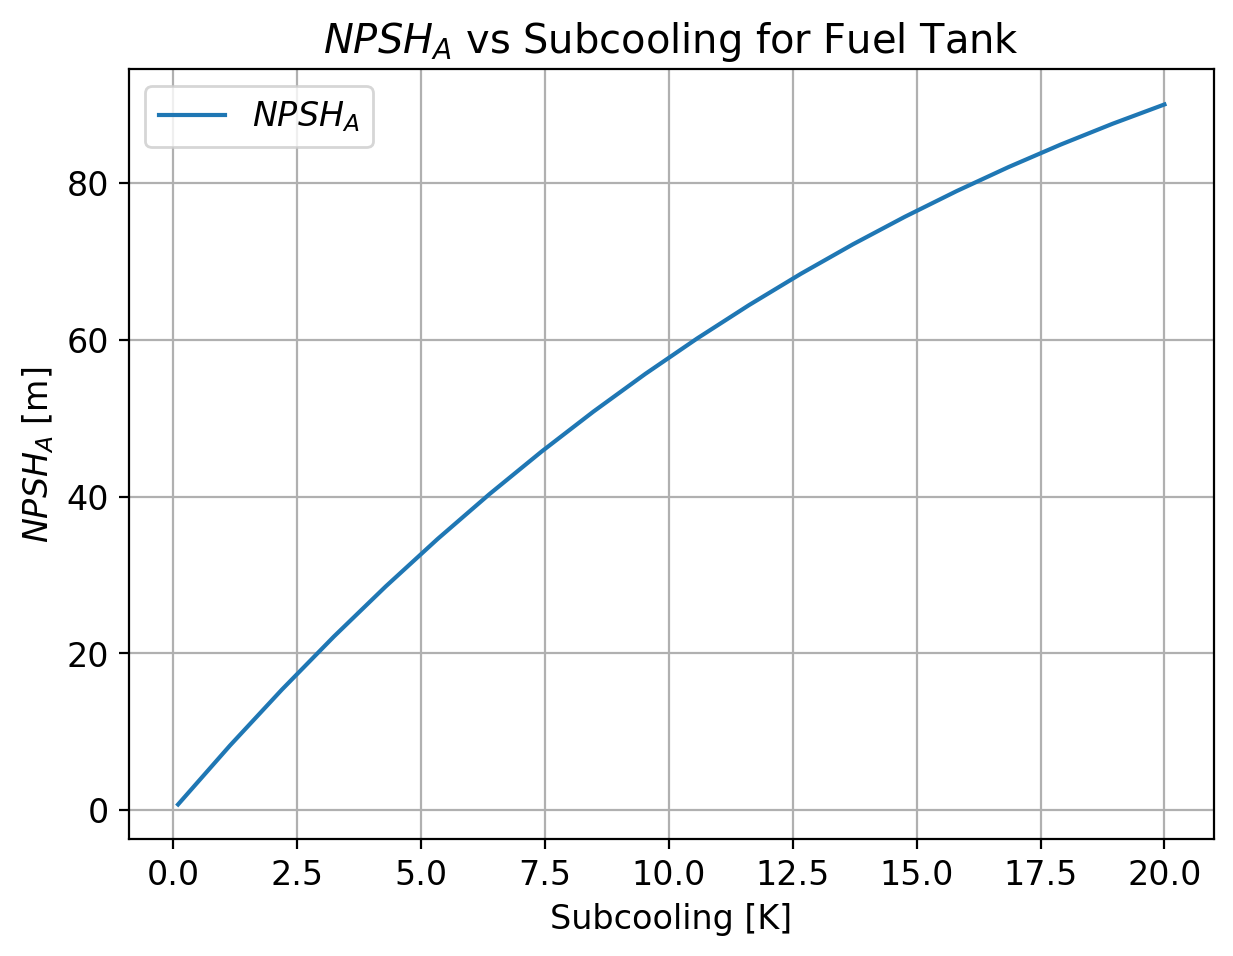

In [ ]:
# Given the above assumption, the NPSH_A may be calculated as function of the subcooling

subcool_array = np.linspace(0.1, 20, 20) * ureg('K')
NPSH_A_array = []

for subcool in subcool_array:
  tank_conditions = storage_conditions(fuel_cp[0], subcool, fuel_tank['p_storage']*ureg('Pa'))
  T_storage = tank_conditions['T_storage']
  rho_storage = tank_conditions['rho_storage']
  P_vap = Q_(CP.PropsSI('P','T',T_storage.m_as('K'),'Q',1,fuel_cp[0]), 'Pa')
  NPSH_A = ( (fuel_tank['p_storage']*ureg('Pa') - P_vap) / (g0 * rho_storage) ).to('m')
  NPSH_A_array.append(NPSH_A.m_as('m'))

# Plot NPSH_A vs Subcooling
plt.figure(figsize=(7,5))
plt.plot(subcool_array.m_as('K'), NPSH_A_array, label='$NPSH_A$')
plt.xlabel('Subcooling [K]')
plt.ylabel('$NPSH_A$ [m]')
plt.title('$NPSH_A$ vs Subcooling for Fuel Tank')
plt.grid(True)
plt.legend()
plt.show()

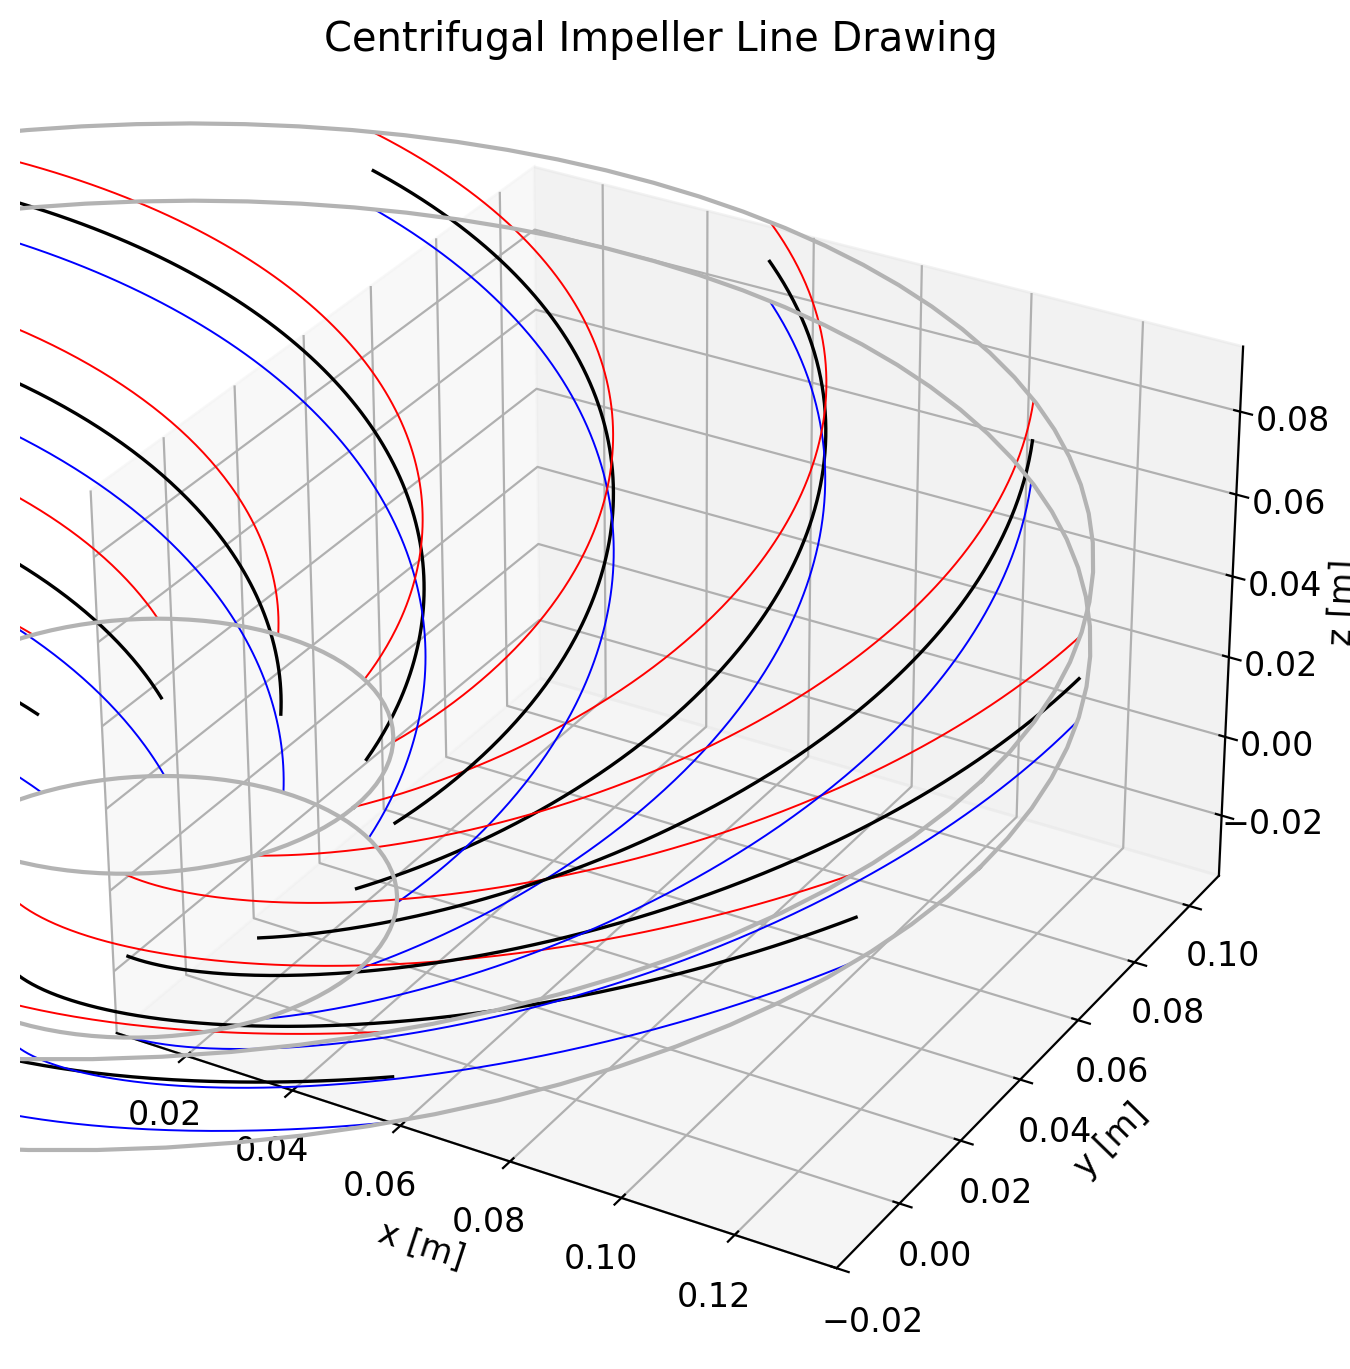

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

def generate_impeller(
    D_in,
    D_out,
    beta_in_deg,
    beta_out_deg,
    n_blades,
    z_in=0.0,
    z_out=0.05,
    b_in=0.03,
    b_out=0.01,
    n_radial=200,
    plot_hub_shroud=True,
):
    """
    Generate a simple 3D line drawing of a centrifugal compressor/pump impeller.

    Parameters
    ----------
    D_in : float
        Inlet diameter (m) at the leading edge, midspan radius.
    D_out : float
        Outlet diameter (m) at the trailing edge, midspan radius.
    beta_in_deg : float
        Inlet blade metal angle in degrees, measured from the tangential direction.
        (beta = 0° is purely tangential; beta = 90° is purely radial.)
    beta_out_deg : float
        Exit blade metal angle in degrees, same convention as beta_in_deg.
    n_blades : int
        Number of blades.
    z_in : float, optional
        Axial position of leading edge (m).
    z_out : float, optional
        Axial position of trailing edge (m).
    b_in : float, optional
        Blade span (hub-to-shroud width) at inlet (m).
    b_out : float, optional
        Blade span at outlet (m).
    n_radial : int, optional
        Number of radial discretization points along each blade.
    plot_hub_shroud : bool, optional
        If True, draw simple hub/shroud circles at inlet and outlet.

    Notes
    -----
    - The blade centerline is computed by integrating:
          dθ/dr = 1 / (r * tan(β(r)))
      where β(r) is interpolated linearly from β_in to β_out.
    - This is a geometric blade shape model only; it is not a full CFD-ready surface.
    """
    # Radii
    r_in = D_in / 2.0
    r_out = D_out / 2.0

    # Radial distribution along the blade (midspan)
    r = np.linspace(r_in, r_out, n_radial)

    # Linear variation of metal angle β from inlet to outlet
    beta_in = np.deg2rad(beta_in_deg)
    beta_out = np.deg2rad(beta_out_deg)
    beta_r = beta_in + (beta_out - beta_in) * (r - r_in) / (r_out - r_in)

    # Avoid tan(beta)=0 where beta≈0°
    eps = 1e-6
    tan_beta = np.tan(beta_r)
    tan_beta = np.where(np.abs(tan_beta) < eps, np.sign(tan_beta) * eps, tan_beta)

    # Integrate dθ/dr = 1 / (r * tan(β(r))) numerically to get θ(r) (base blade)
    theta = np.zeros_like(r)
    for i in range(1, len(r)):
        r_mid = 0.5 * (r[i] + r[i-1])
        beta_mid = 0.5 * (beta_r[i] + beta_r[i-1])
        tan_beta_mid = np.tan(beta_mid)
        if abs(tan_beta_mid) < eps:
            tan_beta_mid = np.sign(tan_beta_mid) * eps
        dtheta = (r[i] - r[i-1]) / (r_mid * tan_beta_mid)
        theta[i] = theta[i-1] + dtheta

    # Normalize so the first blade starts at theta=0 at the inlet
    theta -= theta[0]

    # Simple linear axial position and span (hub–shroud width) vs radius
    z_center = z_in + (z_out - z_in) * (r - r_in) / (r_out - r_in)
    b_span = b_in + (b_out - b_in) * (r - r_in) / (r_out - r_in)

    # 3D plotting
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Generate and plot each blade (midspan line + hub & shroud edges)
    for k in range(n_blades):
        theta_offset = theta + 2.0 * np.pi * k / n_blades

        # Midspan line
        x_mid = r * np.cos(theta_offset)
        y_mid = r * np.sin(theta_offset)
        z_mid = z_center
        ax.plot3D(x_mid, y_mid, z_mid, 'k', linewidth=1.2)

        # Hub and shroud edges (optional)
        # hub = midspan - b/2, shroud = midspan + b/2
        x_hub = r * np.cos(theta_offset)
        y_hub = r * np.sin(theta_offset)
        z_hub = z_center - 0.5 * b_span

        x_shr = r * np.cos(theta_offset)
        y_shr = r * np.sin(theta_offset)
        z_shr = z_center + 0.5 * b_span

        ax.plot3D(x_hub, y_hub, z_hub, 'b', linewidth=0.7)
        ax.plot3D(x_shr, y_shr, z_shr, 'r', linewidth=0.7)

    if plot_hub_shroud:
        # Simple hub & shroud circles at inlet and outlet
        n_circ = 100
        th_c = np.linspace(0, 2*np.pi, n_circ)

        # Inlet hub/shroud
        for sign, color in [(-1, '0.7'), (1, '0.7')]:
            z_c = z_in + sign * b_in / 2.0
            x_c = r_in * np.cos(th_c)
            y_c = r_in * np.sin(th_c)
            ax.plot3D(x_c, y_c, z_c, color)

        # Outlet hub/shroud
        for sign, color in [(-1, '0.7'), (1, '0.7')]:
            z_c = z_out + sign * b_out / 2.0
            x_c = r_out * np.cos(th_c)
            y_c = r_out * np.sin(th_c)
            ax.plot3D(x_c, y_c, z_c, color)

    # Formatting
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    ax.set_title("Centrifugal Impeller Line Drawing")

    # Equal aspect ratio
    max_range = np.array([
        np.max([x_mid.max(), y_mid.max(), z_mid.max()]) - np.min([x_mid.min(), y_mid.min(), z_mid.min()])
    ])[0] / 2.0
    mid_x = (x_mid.max() + x_mid.min()) * 0.5
    mid_y = (y_mid.max() + y_mid.min()) * 0.5
    mid_z = (z_mid.max() + z_mid.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Example usage
    generate_impeller(
        D_in=0.08,       # 80 mm inlet diameter
        D_out=0.30,      # 300 mm outlet diameter
        beta_in_deg=60,  # inlet metal angle from tangential
        beta_out_deg=25, # exit metal angle from tangential
        n_blades=12,
        z_in=0.0,
        z_out=0.06,
        b_in=0.04,
        b_out=0.02
    )